# INF-482, v0.01, Claudio Torres, ctorres@inf.utfsm.cl. DI-UTFSM
### Textbook: Gregory E. Fasshauer, Meshfree Approximaition Methods with MatLab, Interdisciplinary Mathematical Sciences - Vol. 6, World Scientific Publishers, Singapore, 2007. Link: http://www.math.iit.edu/~fass/

# Mairhuber-Curtis Theorem, Halton, Distance Matrix and RBF Interpolation

In [1]:
import numpy as np
import ghalton
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact
from scipy.spatial import distance_matrix
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import IntSlider
import sympy as sym
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
sym.init_printing()
M=8

In [2]:
def plot_matrices_with_values(ax,M):
    N=M.shape[0]
    cmap = plt.get_cmap('GnBu')
    ax.matshow(M, cmap=cmap)
    for i in np.arange(0, N):
        for j in np.arange(0, N):
            ax.text(i, j, '{:.2f}'.format(M[i,j]), va='center', ha='center', color='r')

## Mairhuber-Curtis Theorem

In [3]:
# Initializing a R^2
sequencer = ghalton.Halton(2)
sequencer.reset()
xH=np.array(sequencer.get(9))
print(xH)

[[ 0.5         0.33333333]
 [ 0.25        0.66666667]
 [ 0.75        0.11111111]
 [ 0.125       0.44444444]
 [ 0.625       0.77777778]
 [ 0.375       0.22222222]
 [ 0.875       0.55555556]
 [ 0.0625      0.88888889]
 [ 0.5625      0.03703704]]


In [4]:
def show_MC_theorem(s_local=0):
    i=3
    j=4
    NC=40

    sequencer.reset()
    xH=np.array(sequencer.get(9))

    phi1= lambda s: (s-0.5)*(s-1)/((0-0.5)*(0-1))
    phi2= lambda s: (s-0)*(s-1)/((0.5-0)*(0.5-1))
    phi3= lambda s: (s-0)*(s-0.5)/((1-0)*(1-0.5))
    C1=lambda s: xH[i,:]*phi1(s)+np.array([0.45,0.55])*phi2(s)+xH[j,:]*phi3(s)
    C2=lambda s: xH[j,:]*phi1(s)+np.array([0.15,0.80])*phi2(s)+xH[i,:]*phi3(s)
    C1v=np.vectorize(C1,otypes=[np.ndarray])
    C2v=np.vectorize(C2,otypes=[np.ndarray])
    ss=np.linspace(0,1,NC).reshape((-1, 1))
    C1o=np.array(C1v(ss))
    C2o=np.array(C2v(ss))
    C1plot=np.zeros((NC,2))
    C2plot=np.zeros((NC,2))
    for k in np.arange(0,NC):
        C1plot[k,0]=C1o[k][0][0]
        C1plot[k,1]=C1o[k][0][1]
        C2plot[k,0]=C2o[k][0][0]
        C2plot[k,1]=C2o[k][0][1]

    plt.figure(figsize=(2*M,M))
    plt.subplot(121)
    plt.plot(C1plot[:,0],C1plot[:,1],'r--')
    plt.plot(C2plot[:,0],C2plot[:,1],'g--')
    plt.scatter(xH[:,0], xH[:,1], s=300, c="b", alpha=1.0, marker='.',
                label="Halton")
    plt.scatter(C1(s_local)[0], C1(s_local)[1], s=300, c="r", alpha=1.0, marker='d')
    plt.scatter(C2(s_local)[0], C2(s_local)[1], s=300, c="g", alpha=1.0, marker='d')
    plt.axis([0,1,0,1])
    plt.title(r'Quasi-random points (Halton)')
    plt.grid(True)

    xHm=np.copy(xH)
    xHm[i,:]=C1(s_local)
    xHm[j,:]=C2(s_local)
    R=distance_matrix(xHm, xH)
    det_s_local=np.linalg.det(R)

    plt.subplot(122)
    plt.title(r'det(R_fixed)='+str(det_s_local))
    det_s=np.zeros_like(ss)
    for k, s in enumerate(ss):
        xHm[i,:]=C1plot[k,:]
        xHm[j,:]=C2plot[k,:]
        R=distance_matrix(xHm, xH)
        det_s[k]=np.linalg.det(R)

    plt.plot(ss,det_s,'-')
    plt.plot(s_local,det_s_local,'dk',markersize=16)
    plt.grid(True)

    plt.show()

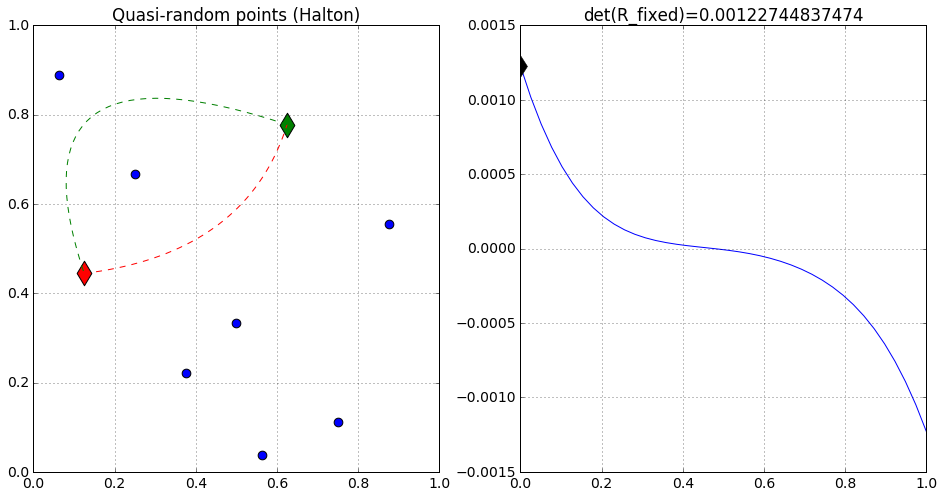

<function __main__.show_MC_theorem>

In [5]:
interact(show_MC_theorem,s_local=(0,1,0.1))

## Halton points vs pseudo-random points in 2D

In [6]:
def plot_random_vs_Halton(n=100):
    # Number of points to be generated
    # n=1000
    # I am reseting the sequence everytime I generated just to get the same points
    sequencer.reset()
    xH=np.array(sequencer.get(n))
    np.random.seed(0)
    xR=np.random.rand(n,2)

    plt.figure(figsize=(2*M,M))

    plt.subplot(121)
    plt.scatter(xR[:,0], xR[:,1], s=100, c="r", alpha=1.0, marker='.',
                label="Random", edgecolors='None')
    plt.axis([0,1,0,1])
    plt.title(r'Pseudo-random points')
    plt.grid(True)

    plt.subplot(122)
    plt.scatter(xH[:,0], xH[:,1], s=100, c="b", alpha=1.0, marker='.',
                label="Halton")
    plt.axis([0,1,0,1])
    plt.title(r'Quasi-random points (Halton)')
    plt.grid(True)

    plt.show()

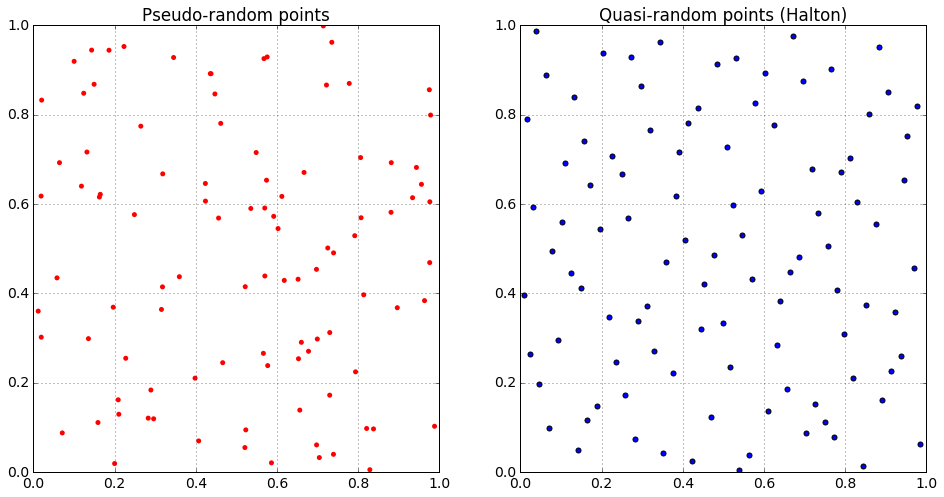

<function __main__.plot_random_vs_Halton>

In [7]:
interact(plot_random_vs_Halton,n=(20,500,20))

## Interpolation with Distance Matrix from Halton points

In [8]:
def show_R(mH=10):
    fig= plt.figure(figsize=(2*M*mH/12,M*mH/12))
    ax = plt.gca()
    sequencer.reset()
    X=np.array(sequencer.get(mH))
    R=distance_matrix(X, X)
    plot_matrices_with_values(ax,R)

<function __main__.show_R>

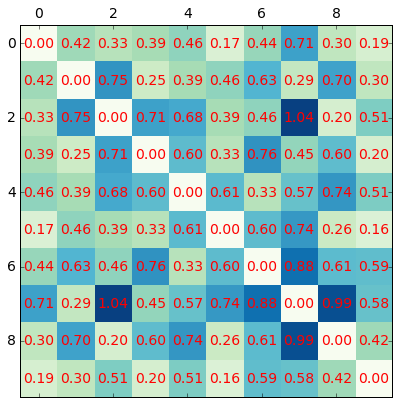

In [9]:
interact(show_R,mH=(2,20,1))

### Defining a test function

In [10]:
# The function to be interpolated
f=lambda x,y: 16*x*(1-x)*y*(1-y)

In [11]:
def showing_f(n=10, elev=40, azim=230):
    fig = plt.figure(figsize=(2*M,M))

    # Creating regular mesh
    Xr = np.linspace(0, 1, n)
    Xm, Ym = np.meshgrid(Xr,Xr)
    Z = f(Xm,Ym)

    # Wireframe
    plt.subplot(221,projection='3d')
    ax = fig.gca()
    ax.plot_wireframe(Xm, Ym, Z)
    ax.view_init(elev,azim)

    # imshow
    plt.subplot(222)
    #plt.imshow(Z,interpolation='none', extent=[0, 1, 0, 1])
    plt.contourf(Xm, Ym, Z, 20)
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.axis('equal')
    plt.xlim(0,1)
    plt.colorbar()

    # Contour plot
    plt.subplot(223)
    plt.contour(Xm, Ym, Z, 20)
    plt.axis('equal')
    plt.colorbar()
    
    # Surface
    plt.subplot(224,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(Xm, Ym, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)
    ax.view_init(elev,azim)

    plt.show()


### Let's look at $f$

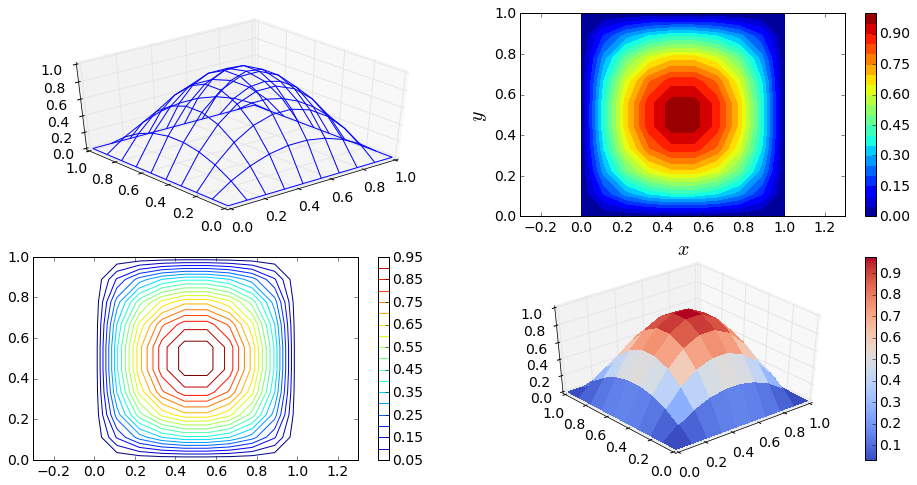

<function __main__.showing_f>

In [12]:
elev_widget = IntSlider(min=0, max=180, step=10, value=40)
azim_widget = IntSlider(min=0, max=360, step=10, value=230)

interact(showing_f,n=(5,50,5),elev=elev_widget,azim=azim_widget)

In [13]:
def eval_interp_distance_matrix(C,X,x,y):
    R=distance_matrix(X, np.array([[x,y]]))
    return np.dot(C,R)

def showing_f_interpolated(n=10, mH=10, elev=40, azim=230):
    fig = plt.figure(figsize=(2*M,M))

    ## Building distance matrix and solving linear system
    sequencer.reset()
    X=np.array(sequencer.get(mH))
    R=distance_matrix(X, X)
    Zs=f(X[:,0],X[:,1])
    C=np.linalg.solve(R,Zs)
    # f interpolated with distance function
    fIR=np.vectorize(eval_interp_distance_matrix, excluded=[0,1])

    # Creating regular mesh
    Xr = np.linspace(0, 1, n)
    Xm, Ym = np.meshgrid(Xr,Xr)
    Z = f(Xm,Ym)

    # Contour plot - Original Data
    plt.subplot(221)
    plt.contour(Xm, Ym, Z, 20)
    plt.colorbar()
    plt.axis('equal')
    plt.title(r'$f(x,y)$')

    # Surface - Original Data
    plt.subplot(222,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(Xm, Ym, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)
    ax.view_init(elev,azim)
    plt.title(r'$f(x,y)$')

    # Contour plot - Interpolated Data
    plt.subplot(223)
    plt.contour(Xm, Ym, fIR(C,X,Xm,Ym), 20)
    plt.axis('equal')
    plt.colorbar()
    plt.scatter(X[:,0], X[:,1], s=100, c="r", alpha=0.5, marker='.',
                label="Random", edgecolors='None')
    plt.title(r'$fIR(x,y)$')

    # Surface - Interpolated Data
    plt.subplot(224,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(Xm, Ym,  fIR(C,X,Xm,Ym), rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)
    ax.view_init(elev,azim)
    ax.set_zlim(0,1)
    plt.title(r'$fIR(x,y)$')

    plt.show()

### The interpolation with distance matrix itself

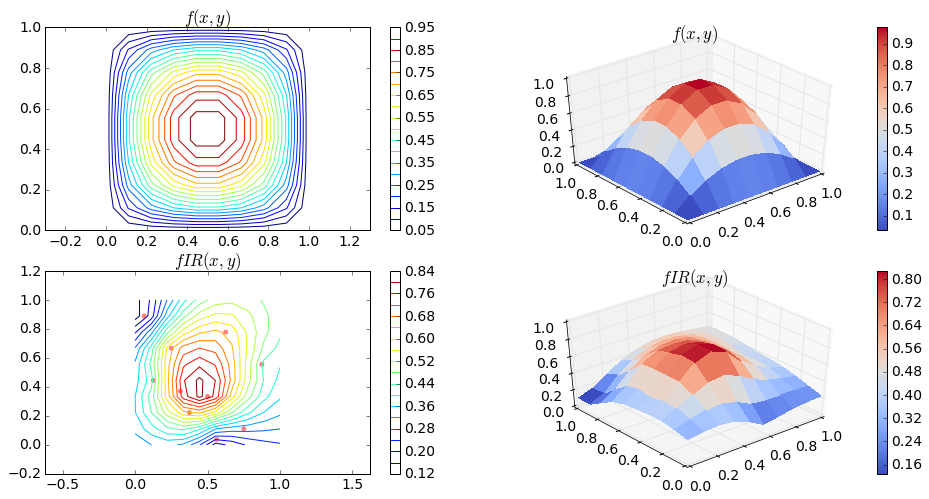

<function __main__.showing_f_interpolated>

In [14]:
interact(showing_f_interpolated,n=(5,50,5),mH=(5,80,5),elev=elev_widget,azim=azim_widget)

## RBF interpolation

In [15]:
# Some RBF's
linear_rbf   = lambda r,eps: r
gaussian_rbf = lambda r,eps: np.exp(-(eps*r)**2)
MQ_rbf       = lambda r,eps: np.sqrt(1+(eps*r)**2)
IMQ_rbf      = lambda r,eps: 1./np.sqrt(1+(eps*r)**2)
# The chosen one! But please try all of them!
rbf          = lambda r,eps: MQ_rbf(r,eps)

In [16]:
def eval_interp_rbf(C,X,x,y,eps):
    A=rbf(distance_matrix(X, np.array([[x,y]])),eps)
    return np.dot(C,A)

def showing_f_interpolated_rbf(n=10, mH=10, elev=40, azim=230, eps=1):
    fig = plt.figure(figsize=(2*M,M))

    # Creating regular mesh
    Xr = np.linspace(0, 1, n)
    Xm, Ym = np.meshgrid(Xr,Xr)
    Z = f(Xm,Ym)
    
    ########################################################
    ## Pseudo-random
    ## Building distance matrix and solving linear system
    np.random.seed(0)
    X=np.random.rand(mH,2)
    R=distance_matrix(X,X)
    A=rbf(R,eps)
    Zs=f(X[:,0],X[:,1])
    C=np.linalg.solve(A,Zs)
    # f interpolated with distance function
    fIR=np.vectorize(eval_interp_rbf, excluded=[0,1,4])
    
    # Contour plot - Original Data
    plt.subplot(231)
    plt.contour(Xm, Ym, fIR(C,X,Xm,Ym,eps), 20)
    plt.colorbar()
    plt.scatter(X[:,0], X[:,1], s=100, c="r", alpha=0.5, marker='.',
                label="Random", edgecolors='None')
    plt.title(r'$f(x,y)_{rbf}$ with Pseudo-random points')

    # Surface - Original Data
    plt.subplot(232,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(Xm, Ym, fIR(C,X,Xm,Ym,eps), rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)
    ax.view_init(elev,azim)
    ax.set_zlim(0,1)
    plt.title(r'$f(x,y)_{rbf}$ with Pseudo-random points')
    
    # Contour plot - Original Data
    plt.subplot(233)
    plt.contourf(Xm, Ym, np.abs(f(Xm,Ym)-fIR(C,X,Xm,Ym,eps)), 20)
    #plt.imshow(np.abs(f(Xm,Ym)-fIR(C,X,Xm,Ym,eps)),interpolation='none', extent=[0, 1, 0, 1])
    plt.axis('equal')
    plt.xlim(0,1)
    plt.colorbar()
    plt.scatter(X[:,0], X[:,1], s=100, c="k", alpha=0.8, marker='.',
                label="Random", edgecolors='None')
    plt.title(r'Error with Pseudo-random points')
    
    ########################################################
    
    ## HALTON (Quasi-random)
    ## Building distance matrix and solving linear system
    sequencer.reset()
    X=np.array(sequencer.get(mH))
    R=distance_matrix(X,X)
    A=rbf(R,eps)
    Zs=f(X[:,0],X[:,1])
    C=np.linalg.solve(A,Zs)
    # f interpolated with distance function
    fIR=np.vectorize(eval_interp_rbf, excluded=[0,1,4])

    # Contour plot - Interpolated Data
    plt.subplot(234)
    plt.contour(Xm, Ym, fIR(C,X,Xm,Ym,eps), 20)
    plt.colorbar()
    plt.scatter(X[:,0], X[:,1], s=100, c="r", alpha=0.5, marker='.',
                label="Random", edgecolors='None')
    plt.title(r'$f_{rbf}(x,y)$ with Halton points')

    # Surface - Interpolated Data
    plt.subplot(235,projection='3d')
    ax = fig.gca()
    surf = ax.plot_surface(Xm, Ym,  fIR(C,X,Xm,Ym,eps), rstride=1, cstride=1, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf)
    ax.view_init(elev,azim)
    ax.set_zlim(0,1)
    plt.title(r'$f_{rbf}(x,y)$ with Halton points')

    # Contour plot - Original Data
    plt.subplot(236)
    plt.contourf(Xm, Ym, np.abs(f(Xm,Ym)-fIR(C,X,Xm,Ym,eps)), 20)
    #plt.imshow(np.abs(f(Xm,Ym)-fIR(C,X,Xm,Ym,eps)),interpolation='none', extent=[0, 1, 0, 1])
    plt.axis('equal')
    plt.xlim(0,1)
    plt.colorbar()
    plt.scatter(X[:,0], X[:,1], s=100, c="k", alpha=0.8, marker='.',
                label="Random", edgecolors='None')
    plt.title(r'Error with Halton points')
    
    plt.show()

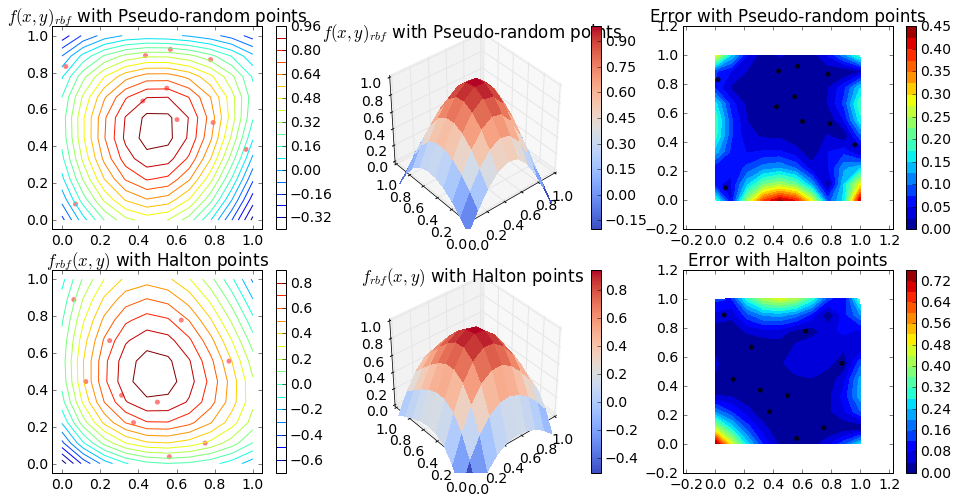

<function __main__.showing_f_interpolated_rbf>

In [17]:
interact(showing_f_interpolated_rbf,n=(5,50,5),mH=(5,80,5),elev=elev_widget,azim=azim_widget,eps=(0.1,50,0.1))